# Regression using Cyclic Boosting

First, install the  package and its dependencies

```sh
!pip install cyclic-boosting
```

In [1]:
import logging

logging.getLogger().setLevel(logging.ERROR)
import warnings

warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from datetime import datetime

# Let's use the test dataset from kaggle

Sign in to Kaggle at the URL below and download the dataset.  
https://www.kaggle.com/datasets/lakshmi25npathi/bike-sharing-dataset

Place the downloaded dataset in the following directory.  
examples/regression/tornado/time_series_bike_demand_forecasting/data/

For time-series data, a "date" column must be included to indicate the date and time the data was obtained. The column name and format must be consistent. The "dayofweek" column for the day of the week and the "dayofyear" column for the total number of days in the year are automatically created if not already present, but if they are already present, the column names must be correct.

This dataset has hourly data. In this dataset, the "instant" column is the data number. The "casual" and "registered" columns are the breakdown of sales, so they should be deleted.

In [3]:
parpath = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
df = pd.read_csv(parpath + "/time_series_bike_demand_forecasting/data/hour.csv")
df = df.rename(columns={"dteday": "date", "weekday": "dayofweek"})
df = df.drop(columns=["instant", "casual", "registered"])
df["date"] = df["date"] + df["hr"].astype("str")
df["date"] = df["date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d%H"))
df.drop(columns=["yr", "mnth", "hr"], inplace=True)

df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)
df_train.to_csv("./bike_sharing_hour_train.csv", index=False)

In [4]:
df.head()

,date,season,holiday,dayofweek,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,1,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01 01:00:00,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01 02:00:00,1,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01 03:00:00,1,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01 04:00:00,1,0,6,0,1,0.24,0.2879,0.75,0.0,1


# Automated Machine Learning with Tornado
With tornado, you can automatically perform data preparation, feature property setting, hyperparameter tuning, model building, training, evaluation, and plotting! (but, It might take a few minutes. Have a coffee break during execution.)

In [5]:
from cyclic_boosting.tornado import generator, manager, model

data_deliverer = generator.TornadoDataModule(df_train)
train, validation = data_deliverer.generate_trainset(test_size=0.2, seed=0, target="cnt", is_time_series=True)
test = data_deliverer.generate_testset(df_test)

training_manager = manager.PriorPredForwardSelectionManager(is_time_series=True, combination=2, dist="nbinom")
predictor = model.PriorPredInteractionSearchModel(training_manager)
predictor.fit("cnt", train, validation, criterion="COD", verbose=False)

preprocessing log is created at /home/tsuruda_yoshito/work/tornado/rPrivate-cyclic-boosting/examples/regression/tornado/time_series_bike_demand_forecasting
[START] Auto feature engineering 
  Original     -> 10 features
  Preprocessed -> 13 features
  Selected     -> 9 features
[END] Auto feature engineering 

[START] Auto analysis 
  Target features: ['temp', 'windspeed', 'lag'] 
  Data interval is 'hourly'
  if it is not correct, set 'data_interval' option at TornadoDataModule
[END] Auto analysis 

Feature properties
    is_unordered: ['holiday', 'dayofweek', 'workingday', 'weathersit', 'dayofyear']
    is_continuous: ['temp', 'windspeed', 'lag']
    has_trend: ['temp', 'windspeed', 'lag']
    has_seasonality: ['temp', 'windspeed', 'lag']
    has_up_monotonicity: []
    has_down_monotonicity: []
    has_linearity: []
    has_missing: ['lag']


=== [START] prior_prediction_with_single_variables ===
iter: 1 / 1 
=== [END] prior_prediction_with_single_variables ===

=== [START] interact

Tornado model is able to point estimation and probability estimation.

25.85772387957681


<Axes: >

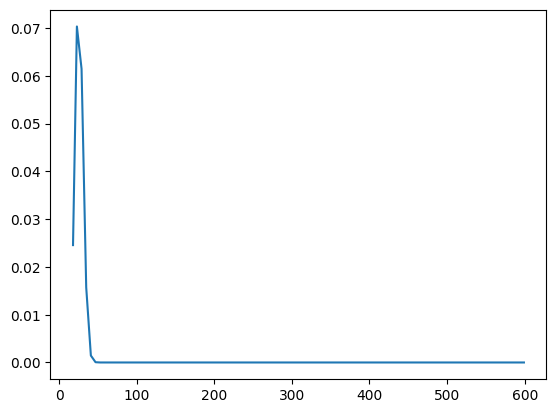

In [6]:
# mean point estimation
yhat = predictor.predict(test)
print(yhat[0])

# probability estimation with negative binomial distribution
proba = predictor.predict_proba(test.head(5), output="pmf")
proba.iloc[0, :].plot()

# Accuracy comparison with plain Cyclic boosting

Tornado can take care of setting the feature properties and interaction terms to obtain a better cyclic boosting model. However, be careful not to over-fitting when the amount of data is small.

In [7]:
from cyclic_boosting import flags, common_smoothers, observers
from cyclic_boosting.pipelines import pipeline_CBPoissonRegressor
from cyclic_boosting.smoothing.onedim import SeasonalSmoother
from sklearn.model_selection import train_test_split
from scipy.stats import poisson
from cyclic_boosting.tornado.trainer.metrics import probability_distribution_accuracy


df_train["dayofyear"] = df_train["date"].dt.dayofyear
df_test["dayofyear"] = df_test["date"].dt.dayofyear
train, _ = train_test_split(df_train, test_size=0.2, shuffle=False)
y_train = np.asarray(train["cnt"])
X_train = train.drop(columns="cnt")
y_val = np.asarray(df_test["cnt"])
X_val = df_test.drop(columns="cnt")
if not all(np.asarray(train["cnt"]) == manager.y):
    raise ValueError(
        "Accuracy comparison is not available because\n" "the data split is not the same as that of tornado."
    )


feature_properties = {
    "season": flags.IS_UNORDERED,
    "dayofweek": flags.IS_ORDERED,
    "dayofyear": flags.IS_CONTINUOUS | flags.IS_LINEAR,
    "holiday": flags.IS_UNORDERED,
    "workingday": flags.IS_UNORDERED,
    "weathersit": flags.IS_UNORDERED,
    "temp": flags.IS_CONTINUOUS,
    "atemp": flags.IS_CONTINUOUS,
    "hum": flags.IS_CONTINUOUS,
    "windspeed": flags.IS_CONTINUOUS,
}

features = [
    "season",
    "dayofweek",
    "dayofyear",
    "holiday",
    "workingday",
    "weathersit",
    "temp",
    "atemp",
    "hum",
    "windspeed",
]

explicit_smoothers = {
    ("dayofyear",): SeasonalSmoother(order=3),
}

plobs = [
    observers.PlottingObserver(iteration=1),
    observers.PlottingObserver(iteration=-1),
]

CB_est = pipeline_CBPoissonRegressor(
    feature_properties=feature_properties,
    feature_groups=features,
    observers=plobs,
    maximal_iterations=50,
    smoother_choice=common_smoothers.SmootherChoiceGroupBy(
        use_regression_type=True,
        use_normalization=False,
        explicit_smoothers=explicit_smoothers,
    ),
)

_ = CB_est.fit(X_train.copy(), y_train)

yhat = predictor.predict(test)
mse_tornado = np.nanmean(np.square(y_val - yhat))
mae_tornado = np.nanmean(np.abs(y_val - yhat))
wmape_tornado = np.nansum(np.abs(y_val - yhat) * y_val) / np.nansum(y_val * y_val)

yhat_pd = predictor.predict_proba(test, output="func")
acc_pd_tornado = probability_distribution_accuracy(y_val, yhat_pd)

yhat = CB_est.predict(X_val.copy())
mse = np.nanmean(np.square(y_val - yhat))
mae = np.nanmean(np.abs(y_val - yhat))
wmape = np.nansum(np.abs(y_val - yhat) * y_val) / np.nansum(y_val * y_val)

yhat_pd = list()
for mu in yhat:
    yhat_pd.append(poisson(mu))
acc_pd = probability_distribution_accuracy(y_val, yhat_pd)

pd.options.display.float_format = "{:.2f}".format
val_results = pd.DataFrame(
    [[np.sqrt(mse_tornado), mae_tornado, wmape_tornado, acc_pd_tornado], [np.sqrt(mse), mae, wmape, acc_pd]],
    columns=["RMSE", "MAE", "WMAPE", "PD_ACC"],
    index=["CB_tornado", "Plain CB"],
)
print(val_results)

             RMSE    MAE  WMAPE  PD_ACC
CB_tornado 190.60 130.37   0.52    0.65
Plain CB   204.46 144.01   0.56    0.07


# Accuracy comparison with LightGBM
Install the lightgbm package before running.  
LightGBM is an excellent approach to non-linear forecasting when sufficient data are available; Tornado addresses the non-linear forecasting task, a problem that linear models cannot easily predict, by automatically searching for interaction terms. By default, it searches for combinations of two variables and can interpret the features captured by the model using plot_analysis. Note that higher-order combinations can also be explored, but complex models may be difficult to interpret while fitting the training data well.

In [8]:
import lightgbm as lgb

In [9]:
X_train_ = X_train.drop(columns="date").copy()
X_val_ = X_val.drop(columns="date").copy()

In [10]:
params = {"objective": "regression", "metric": "rmse", "verbosity": -1}

y_train_ = np.log(y_train)
lgb_train = lgb.Dataset(X_train_, y_train_)
model = lgb.train(params=params, train_set=lgb_train, num_boost_round=500)

yhat = np.exp(model.predict(X_val_))

mse = np.nanmean(np.square(y_val - yhat))
mae = np.nanmean(np.abs(y_val - yhat))
wmape = np.nansum(np.abs(y_val - yhat) * y_val) / np.nansum(y_val * y_val)

pd.options.display.float_format = "{:.5f}".format
val_results = pd.DataFrame(
    [[np.sqrt(mse_tornado), mae_tornado, wmape_tornado], [np.sqrt(mse), mae, wmape]],
    columns=["RMSE", "MAE", "WMAPE"],
    index=["CB_tornado", "LightGBM"],
)
print(val_results)

                RMSE       MAE   WMAPE
CB_tornado 190.59670 130.36566 0.51950
LightGBM   218.16821 149.52031 0.59830
